# In-class transcript from Lecture 2, January 9, 2020


# Imports and defs for lecture

In [1]:
# These are the standard imports for CS 111. 
# This list may change as the quarter goes on.

# Standard system stuff
import os
import math
import time

# Numpy and scipy: arrays, matrices, linear algebra, ODE integrators
import numpy as np
import numpy.linalg as npla
import scipy
import scipy.sparse.linalg as spla
from scipy import sparse
from scipy import linalg
from scipy import integrate

# Matplotlib: plotting routines
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

# Use the next line to make plots come out in the notebook
%matplotlib inline 
# Use the next line to make plots come out in separate windows
# %matplotlib tk 


In [2]:
# Making matrices for the temperature problem (i.e. the discrete Laplacian operator)

# Two dimensions 
def make_A_2D(k):
    """Create the matrix of the discrete Laplacian operator in two dimensions on a k-by-k grid.
    Parameters: 
      k: number of grid points in each dimension.
    Outputs:
      A: the sparse k**2-by-k**2 matrix representing the finite difference approximation to Laplace's equation.
    """
    # First make a list with one triple (row, column, value) for each nonzero element of A
    triples = []
    for x in range(k):
        for y in range(k):
                
            # what row of the matrix is grid point (x,y)?
            row = x + k*y

            # the diagonal element in this row
            col = row
            triples.append((row, col, 4.0))
            # connect to grid neighbors in x dimension
            if x > 0:
                col = row - 1
                triples.append((row, col, -1.0))
            if x < k - 1:
                col = row + 1
                triples.append((row, col, -1.0))
            # connect to grid neighbors in y dimension
            if y > 0:
                col = row - k
                triples.append((row, col, -1.0))
            if y < k - 1:
                col = row + k
                triples.append((row, col, -1.0))

    # Finally convert the list of triples to a scipy sparse matrix
    ndim = k*k
    rownum = [t[0] for t in triples]
    colnum = [t[1] for t in triples]
    values = [t[2] for t in triples]
    A = sparse.csr_matrix((values, (rownum, colnum)), shape = (ndim, ndim))
    
    return A 



def make_A_small():
    """Make a small k=4 version of the temperature matrix, as a dense  array"""
    A = make_A_2D(4)
    return A.toarray()



# Make right-hand side vector for the 2D Poisson equation 

def make_b(k, top = 0, bottom = 0, left = 0, right = 0):
    """Create the right-hand side for the temperature problem on a k-by-k grid.
    Parameters: 
      k: number of grid points in each dimension.
      top: list of k values for top boundary (optional, defaults to 0)
      bottom: list of k values for bottom boundary (optional, defaults to 0)
      left: list of k values for top boundary (optional, defaults to 0)
      right: list of k values for top boundary (optional, defaults to 0)
    Outputs:
      b: the k**2 element vector (as a numpy array) for the rhs of the Poisson equation with given boundary conditions
    """
    # Start with a vector of zeros
    ndim = k*k
    b = np.zeros(shape = ndim)
    
    # Fill in the four boundaries as appropriate
    b[0        : k       ] += top
    b[ndim - k : ndim    ] += bottom
    b[0        : ndim : k] += left
    b[k-1      : ndim : k] += right
    
    return b
    
    
def radiator(k, width = .3, temperature = 100.):
    """Create one wall with a radiator
    Parameters: 
      k: number of grid points in each dimension; length of the wall.
      width: width of the radiator as a fraction of length of the wall (defaults to 0.2)
      temperature: temperature of the radiator (defaults to 100)
    Outputs:
      wall: the k element vector (as a numpy array) for the boundary conditions at the wall
    """
    rad_start = int(k * (0.5 - width/2))
    rad_end = int(k * (0.5 + width/2))
    wall = np.zeros(k)
    wall[rad_start : rad_end] = temperature
    
    return wall



# Lecture starts here

In [3]:
S = np.array([[2,-1],[-1,2]])
S

array([[ 2, -1],
       [-1,  2]])

In [4]:
print(S)

[[ 2 -1]
 [-1  2]]


In [5]:
b = np.array([0,3])
b

array([0, 3])

In [6]:
x = npla.solve(S,b)
x

array([1., 2.])

In [7]:
S @ x

array([0., 3.])

In [8]:
A = make_A_small()
print(A)

[[ 4. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  4. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  4. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  4.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  4. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0. -1.  4. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0. -1.  4. -1.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0. -1.  4.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.  4. -1.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0. -1.  4. -1.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.  0. -1.  4. -1.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  0.  0. -1.  4.  0.  0.  0. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  4. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0. -1.  4. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0. -1.  4. 

In [9]:
b = make_b(4,top=radiator(4))
print(b)

[  0. 100.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.]


In [10]:
t = npla.solve(A,b)

In [11]:
print(t)

[10.21212121 33.90909091 11.54545455  3.8030303   6.93939394 13.87878788
  8.46969697  3.66666667  3.66666667  6.1969697   4.78787879  2.39393939
  1.53030303  2.45454545  2.09090909  1.12121212]


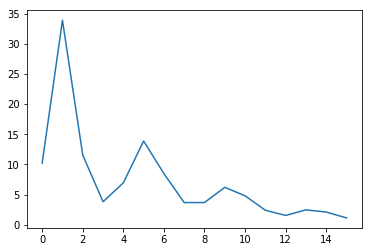

In [12]:
plt.plot(t)

Text(0.5,1,'2-dimensional Poisson equation (temperature)')

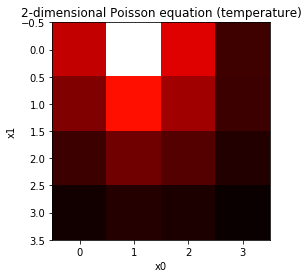

In [13]:
T = t.reshape(4, 4)
plt.figure()
plt.imshow(T, cmap=cm.hot)
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('2-dimensional Poisson equation (temperature)')


In [14]:
S

array([[ 2, -1],
       [-1,  2]])

In [15]:
print(S)

[[ 2 -1]
 [-1  2]]


In [16]:
S + 3

array([[5, 2],
       [2, 5]])

In [17]:
S / 2

array([[ 1. , -0.5],
       [-0.5,  1. ]])

In [18]:
S + S


array([[ 4, -2],
       [-2,  4]])

In [19]:
np.sin(S)

array([[ 0.90929743, -0.84147098],
       [-0.84147098,  0.90929743]])

In [20]:
A = np.arange(16)
A

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [21]:
list(range(16))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [22]:
np.zeros((4,4))

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [23]:
np.ones((4,4))

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

In [24]:
A

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [26]:
A.reshape(4,4)

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

In [27]:
A


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [28]:
A[5]

5

In [29]:
A = A * A
A

array([  0,   1,   4,   9,  16,  25,  36,  49,  64,  81, 100, 121, 144,
       169, 196, 225])

In [30]:
A[5]

25

In [31]:
A[4:8]

array([16, 25, 36, 49])

In [32]:
A[:8]

array([ 0,  1,  4,  9, 16, 25, 36, 49])

In [33]:
A[6:]

array([ 36,  49,  64,  81, 100, 121, 144, 169, 196, 225])

In [34]:
A[2:12:2]

array([  4,  16,  36,  64, 100])

In [35]:
A[::-1]

array([225, 196, 169, 144, 121, 100,  81,  64,  49,  36,  25,  16,   9,
         4,   1,   0])

In [36]:
A = np.random.random((4,4))

In [37]:
A


array([[0.45715704, 0.63482448, 0.78257195, 0.26140153],
       [0.26102666, 0.8465939 , 0.22811479, 0.3480709 ],
       [0.09312856, 0.71625213, 0.639123  , 0.78194761],
       [0.98220315, 0.40728688, 0.32463884, 0.13735984]])

In [38]:
A = np.round(100*A)

In [39]:
A

array([[46., 63., 78., 26.],
       [26., 85., 23., 35.],
       [ 9., 72., 64., 78.],
       [98., 41., 32., 14.]])

In [40]:
A[2,3]

78.0

In [41]:
A[2,:]

array([ 9., 72., 64., 78.])

In [42]:
A[2,::-1]

array([78., 64., 72.,  9.])

In [43]:
A[::-1,::-1]

array([[14., 32., 41., 98.],
       [78., 64., 72.,  9.],
       [35., 23., 85., 26.],
       [26., 78., 63., 46.]])

In [44]:
A

array([[46., 63., 78., 26.],
       [26., 85., 23., 35.],
       [ 9., 72., 64., 78.],
       [98., 41., 32., 14.]])

In [45]:
A[2,0] = 3
A

array([[46., 63., 78., 26.],
       [26., 85., 23., 35.],
       [ 3., 72., 64., 78.],
       [98., 41., 32., 14.]])

In [46]:
A[[0,1],:] = A[[1,0], :]

In [47]:
A

array([[26., 85., 23., 35.],
       [46., 63., 78., 26.],
       [ 3., 72., 64., 78.],
       [98., 41., 32., 14.]])

In [48]:
- A

array([[-26., -85., -23., -35.],
       [-46., -63., -78., -26.],
       [ -3., -72., -64., -78.],
       [-98., -41., -32., -14.]])

In [49]:
A + A

array([[ 52., 170.,  46.,  70.],
       [ 92., 126., 156.,  52.],
       [  6., 144., 128., 156.],
       [196.,  82.,  64.,  28.]])

In [50]:
v = np.arange(4)

In [51]:
v


array([0, 1, 2, 3])

In [52]:
A @ v

array([236., 297., 434., 147.])

In [53]:
v @ A

array([346., 330., 302., 224.])

In [54]:
A = np.arange(9).reshape(3,3)
A

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [55]:
A.transpose()

array([[0, 3, 6],
       [1, 4, 7],
       [2, 5, 8]])

In [56]:
A

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [57]:
A.T

array([[0, 3, 6],
       [1, 4, 7],
       [2, 5, 8]])

In [58]:
A.T.T

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [59]:
A.T.T == A

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [60]:
(A.T.T == A).all()

True

In [61]:
A


array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [62]:
B = A.T

In [63]:
B


array([[0, 3, 6],
       [1, 4, 7],
       [2, 5, 8]])

In [64]:
B @ A

array([[45, 54, 63],
       [54, 66, 78],
       [63, 78, 93]])

In [65]:
np.eye(5)


array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])